In [1]:
# general imports
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error

# for data read
import pickle
import os
#import datetime as dt

# time series model
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# linear regression modell 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Prophet
import prophet as pt

import warnings
warnings.filterwarnings(action='ignore')


In [2]:

def read_selected_stocks(_used_price='Close', 
                         _root_dir=r'c:',
                        _nan_selection_method = 0,
                        _number_of_dropped_stocks = 10,
                        _period_start = '1962-01-02',
                        _period_stop = '2022-12-09'):
    """
    inputs:
        _used_price = 'Close', which data of stocks should be used, opening, closing, adjusted closing
        _root_dir = root_dir, directory where pickle files are stored
        _nan_selection_method = 0, which is 
            0 if shocks with shortest timeseries data will be droped, 
            1 if simple average is used, w/o nan
        _number_of_dropped_stocks = 10, number of shortest stock will be dropped (only if _nan_selection=0)
        _period_start, first time period used 
        _period_stop, last time period used 

        
    output: dataframe contains time series with the average of selected stocks
    """
    # read timeseries date from pickle (df_raw)
    df_raw=pd.read_pickle(_root_dir +r'\50yr_timeSeries_data.pkl')
    
    # prepare & select the approprite value of stock (closing, opening, etc)
    df_close         = df_raw.loc[: ,(slice(None) ,[_used_price])].copy()
    df_close.columns = df_close.columns.droplevel(1)
    
    # read alternative portfolio data
    pickle_in = open( _root_dir +r'\alternate_port.pkl' ,'rb')
    alternate_port = pickle.load(pickle_in)
    
    i = 5
    df = df_close[alternate_port[f'cluster_{i}'].index.values.tolist()].copy()
    
    # create alternative porfolo by dropping nan stocks
    if _nan_selection_method == 0:
        # create temporaly data frame, will be used for selecting the columns from df_
        df_temp=pd.DataFrame(columns=['stock','ind','date','first_value'])

        for c in df.columns:
            i=0 # df.index
            while pd.isnull(df.loc[df.index[i],c]):
                i=i+1
            #print(c,i,df.index[i],df.loc[df.index[i],c])
            new_row={'stock':c,'ind':i, 'date':df.index[i],'first_value': df.loc[df.index[i],c]}
            df_temp.loc[len(df_temp)]=new_row

        # order in descending
        df_temp=df_temp.sort_values(by='ind', ascending=False)

        # lets drop _number_of_dropped_stocks newest stocks (can be changed)
        for i in range(_number_of_dropped_stocks):
            df=df.drop(df_temp.loc[df_temp.index[i],'stock'],axis=1)

        # we drop the history for which we don't have historical data
        df = df.dropna() 
        
        # Create Portfolio using stock weighting
        # Question: How to determine the weighting of each stock in the portfolio?
        dummy_weight = np.array([1/df.shape[1] for x in range(df.shape[1])])
        ticker_weight = dummy_weight # STILL NEED TO DO WEIGHTINGS
    
        # weigthed average of portfolio
        df_port = pd.Series(df.values.dot(ticker_weight) ,index=df.index)
    
    # create alternative porfolo by ignoring nan values from simple (!) average of stocks     
    elif _nan_selection_method == 1:
        df_port=df.mean(axis=1,skipna=True)
    else:
         # TODO - proper error handling
        df_port=df_close
        
    # slice the required set of the data    
    df_port=df_port.loc[_period_start : _period_stop]
    
    return df_port

In [3]:
root_dir= r'c:\Users\Zoli\Downloads\python\academy'

df=read_selected_stocks(_used_price='Close',
                        _root_dir = root_dir,
                        _nan_selection_method=0, 
                        _number_of_dropped_stocks = 10,
                        _period_start='2014-01-01', _period_stop='2021-12-31')
df.head()


Date
2014-01-02    87.011097
2014-01-03    87.107797
2014-01-06    86.849613
2014-01-07    87.543122
2014-01-08    87.650929
dtype: float64

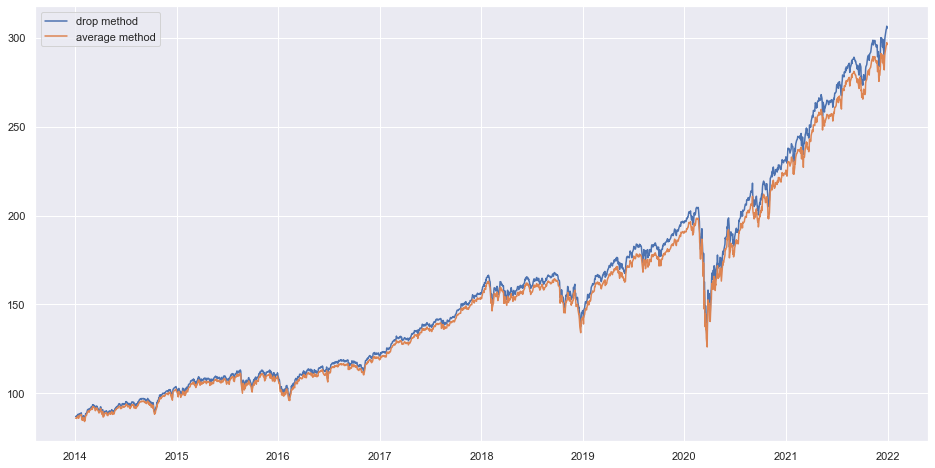

In [4]:
# comparision of two methods
df2=read_selected_stocks(_root_dir = root_dir,_nan_selection_method=1, _period_start='2014-01-01', _period_stop='2021-12-31')

plt.figure(figsize=(16,8))
plt.plot(df, label='drop method')
plt.plot(df2, label='average method');
plt.legend();

In [5]:
def split_df_prediciton(_df=df, _resampling='None'):
    """
    spit the last one year from data frame (input: _df)
    we assumed that data is daily
    input: 
        _df = df, input data frame in time series format (index is time, one column with data)
        _resampling='None' could be 'None', '1W' or '1M', ie. scales down horizon accordingly
    outputs:
        df_train, df_test: splited df

    """
    # params
    if _resampling == '1M':
        horizons = 12 
    elif _resampling == '1W':
        horizons = 52
    elif _resampling == 'None':
        horizons = 52*5 
    else:
        # todo proper error handling, now default is used
        horizons = 52*5

    split_point = _df.shape[0] - horizons
    df_train, df_test = _df[:split_point],_df[split_point:] 

    return df_train, df_test

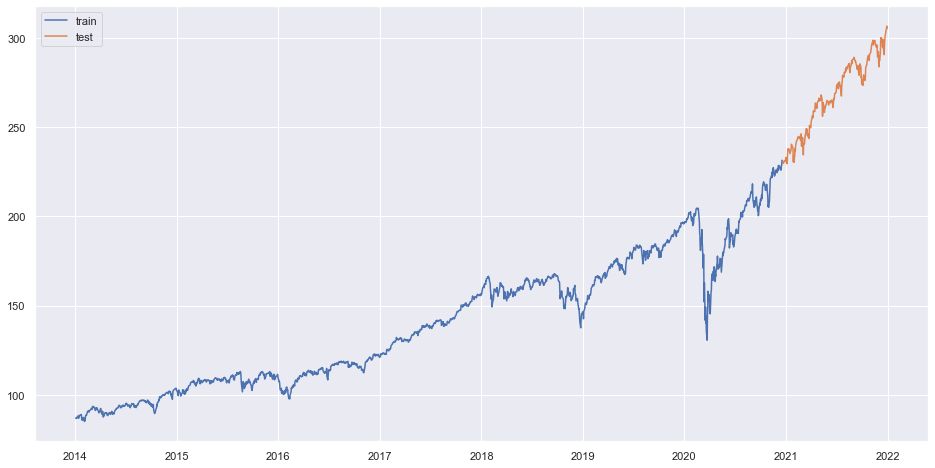

In [6]:
df_train, df_test = split_df_prediciton(df, _resampling='None')

plt.figure(figsize=(16,8))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test');
plt.legend();

In [7]:
def ts_analysis(_df = df, _resampling='1W', _debug=False, _method = 0):
    """
    classicial time series method used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0, not used
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months
        steps = 12
    elif _resampling == '1W':
        lags = 156
        steps = 52
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52
    
    # train test split
    df_train, df_test = split_df_prediciton(_df, _resampling='None')

    # resampling 
    df_train_resampled = df_train.resample(_resampling).mean() 
    df_test_resampled = df_test.resample(_resampling).mean()
    
    # overwrite steps
    steps = df_test_resampled.shape[0]
    
    # plot - if _debug is True
    if _debug == True:
        plt.figure(figsize=(16,8))
        plt.plot(df_train_resampled);

        tsa =seasonal_decompose(df_train_resampled)
        fig=tsa.plot()
        fig.set_size_inches((16, 8))
        fig.tight_layout()
        plt.show();
    
    # log transform + diffs
    df_train_resampled_log = np.log(df_train_resampled) 

    df_train_resampled_log_1 = df_train_resampled_log.diff().dropna()
    
    if _debug == True:
        pd.plotting.autocorrelation_plot(df_train_resampled_log_1);
        res=sm.tsa.stattools.adfuller(df_train_resampled_log_1)
        print ("First order diff transformation p-value:",res[1])


    df_train_resampled_log_2 = df_train_resampled_log_1.diff().dropna()
    if _debug == True:
        pd.plotting.autocorrelation_plot(df_train_resampled_log_2);
        res=sm.tsa.stattools.adfuller(df_train_resampled_log_2)
        print ("Second order diff transformation p-value:",res[1])
    
    # auto correlation functions of second order diff
    if _debug == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
        
        plot_acf(df_train_resampled_log_2,lags = lags,ax=ax1)  ## was 36 in case on 1M
        plot_pacf(df_train_resampled_log_2,lags = lags,ax=ax2) ## was 36 in case on 1M
        
        plt.show();
    
    # SARIMA fit default: (1,1,1)
    model_sm = sm.tsa.SARIMAX(df_train_resampled_log, order=(0,1,1), seasonal_order = (0,1,1,52))  ## 1M: seasonal_order = (0,1,1,12)
    model_sm_fitted = model_sm.fit()
    print(model_sm_fitted.summary())

    # Forecasting with a confidence interval    
    prediction_log = model_sm_fitted.get_forecast(steps = steps).summary_frame()  
    prediction = np.exp(prediction_log)

    fig, ax = plt.subplots(figsize = (15,5))

    plt.plot(df_train_resampled, label = "train")
    plt.plot(df_test_resampled, label = "test")
    #plt.ylim(0,300) # v006

    prediction['mean'].plot(ax = ax, style = 'k--', label = "prediction") # Plotting the mean

    ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); 
    plt.axvline(x= df_test.index[0], color='orange'); 
    plt.legend()
    
    # calculate RMSE
    rmse =  np.sqrt(mean_squared_error(df_test_resampled, prediction['mean']))
    
    return np.round(rmse,4)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  364
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                 756.131
Date:                            Sun, 23 Apr 2023   AIC                          -1506.262
Time:                                    19:10:16   BIC                          -1495.042
Sample:                                01-05-2014   HQIC                         -1501.777
                                     - 12-20-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2905      0.022     13.131      0.000       0.247       0.334
ma.S.L52      -0.6676      0.096   

24.0614

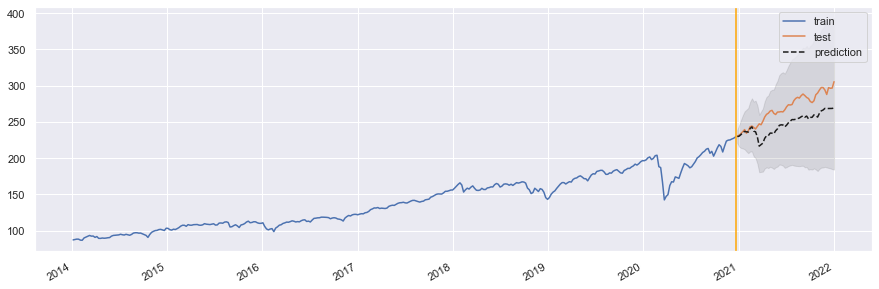

In [8]:
ts_analysis(df, _resampling = '1W', _debug = False)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                  42.046
Date:                            Sun, 23 Apr 2023   AIC                            -78.092
Time:                                    19:10:18   BIC                            -73.790
Sample:                                01-31-2014   HQIC                           -76.690
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1323      0.181      0.731      0.465      -0.223       0.487
ma.S.L52    2.215e-05   1.51e-10   

17.2654

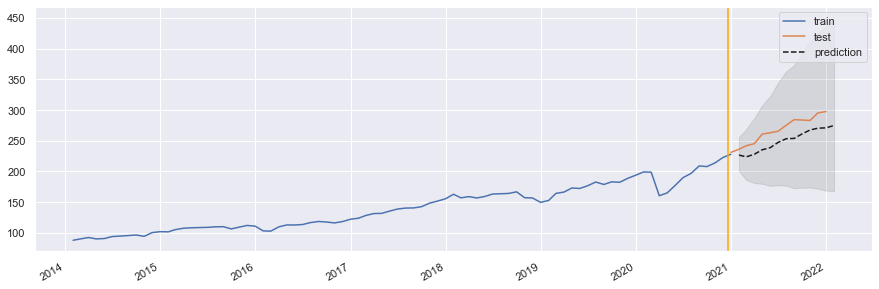

In [9]:
ts_analysis(df, _resampling = '1M', _debug = False)

In [10]:
def lin_analysis(_df = df, _resampling='1W', _debug=False, _method = 0):
    """
    linear regression method based forecast used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0 , 0: RandomForestRegressior, 1: Naiv, 2: Sesional naiv, 3: direct with RFR
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months TODO: lags is not used, but should be instead of steps
        steps = 12
    elif _resampling == '1W':
        lags = 156
        steps = 52
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52

    # resampling
    df_resampled = _df.resample(_resampling).mean() 
    
    # create data frame
    df_lin = pd.DataFrame(df_resampled,index=df_resampled.index)
    df_lin['Time'] = np.arange(len(df_lin.index))
    df_lin.columns = ['Stock','Time']
    
    # create month/year as variable
    df_lin['Month'] = df_lin.index.month
    df_lin['Year'] = df_lin.index.year
    
    # create lags as variable
    for i in range(12,18,1):
        df_lin['Lag_'+ str(i)] = df_lin.Stock.shift(i)
    df_lin['Lag_24'] = df_lin.Stock.shift(24)
    
    # remove nan-s due to lags
    df_lin = df_lin.dropna(axis=0)

    # train test split
    df_train_lin, df_test_lin = split_df_prediciton(df_lin,_resampling = _resampling)
    
    # overwrite steps -- TODO not used, remove
    steps = df_test_lin.shape[0]

    # split of target variables from features
    X_train = df_train_lin[df_train_lin.columns[2:]] ## 2 is used because Time column is there, otherwise 1
    y_train = df_train_lin['Stock']
    
    # split of target variables from features
    X_test = df_test_lin[df_test_lin.columns[2:]] ## 2 is used because Time column is there, otherwise 1
    y_test = df_test_lin['Stock']
    
    if _method == 0:
        # Random forest regressor
        
        # model
        model = RandomForestRegressor(n_estimators=100)
        model.fit(X_train, y_train)

        # prediction
        y_pred = model.predict(X_test)

        # plot feature importance
        if _debug == True:
            feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            feat_importances.nlargest(15).sort_values().plot(kind='barh', title='Feature Importance');

        rmse =  np.sqrt(mean_squared_error(y_test, y_pred)) 

        # for plot:
        y_pred_plot = y_pred
        y_pred_legend = 'Random Forest Regressor'
        
    elif _method == 1:
        # naiv approach
        
        forecast = np.mean(df_train_lin['Stock'][-lags:]) # was 24 
        y_pred_mean = np.ones(steps,)*forecast # was 12

        rmse =  np.sqrt(mean_squared_error(y_test, y_pred_mean)) 

        # for plot:
        y_pred_plot = y_pred_mean
        y_pred_legend = 'Naiv approach'

    elif _method == 2:
        # sesional
        
        y_pred_seas = df_train_lin['Stock'][-steps:] # was 12
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_seas))

        # for plot:
        y_pred_plot = y_pred_seas
        y_pred_legend = 'Benchmark Seasonal naive'
    elif _method == 3:
        for i in range(1,steps,1): # was 12 but it works with 1M only
            df_lin['Lag_'+str(i)] = df_lin.Stock.shift(i)
        
        horizons = steps
        cutoff_index = df_lin.shape[0]-horizons

        predictions = []
        pred_index = []
        y_true_m3 = []
        
        for h in np.arange(1,horizons+1,1):
            train, test = df_lin[(steps*2):cutoff_index], df_lin[cutoff_index:cutoff_index+h] # was 24
            if h != 1:
                if _debug == True:
                    print("Horizon: ", h)
                    print("Columns: ", df_lin.columns[1:-h+1])
                    print("")
                X_train_m3 = train[df_lin.columns[1:-h+1]]
                X_test_m3 = test[df_lin.columns[1:-h+1]]
            else: 
                if _debug == True:
                    print("Horizon: ", h)
                    print("Columns: ", df_lin.columns[1:])
                X_train_m3 = train[df_lin.columns[1:]]
                X_test_m3 = test[df_lin.columns[1:]]
                
            y_train_m3 = train['Stock']
            y_test_m3 = test['Stock']
            
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train_m3, y_train_m3)
            
            y_pred_m3 = model.predict(X_test_m3)
            predictions.append(y_pred_m3[h-1])
            pred_index.append(X_test_m3.index[h-1])
            y_true_m3.append(y_test_m3[h-1])

        rmse = np.sqrt(mean_squared_error(y_true_m3, predictions))

        y_pred_plot = predictions
        y_pred_legend = 'Direct approach with Random Forest Regressor'
        
    else:
        # do nothing, should drop an error
        rmse = 0
        
        y_pred_plot = y_test
        y_pred_legend = 'Empty method'

    
    # plot
    fig, ax = plt.subplots(figsize = (15,5))

    plt.plot(df_train_lin.index, df_train_lin.Stock, c='b', label='train')
    plt.plot(X_test.index, y_test, c='orange', label='test')
    plt.plot(X_test.index, y_pred_plot, c = 'r', label='prediction')
    plt.axvline(x= df_test_lin.index[0], color='orange'); 
    plt.legend()

    plt.xlabel('Time')
    plt.ylabel('Stock')
    plt.title(y_pred_legend)
    plt.show()
    
    return np.round(rmse,4)
    

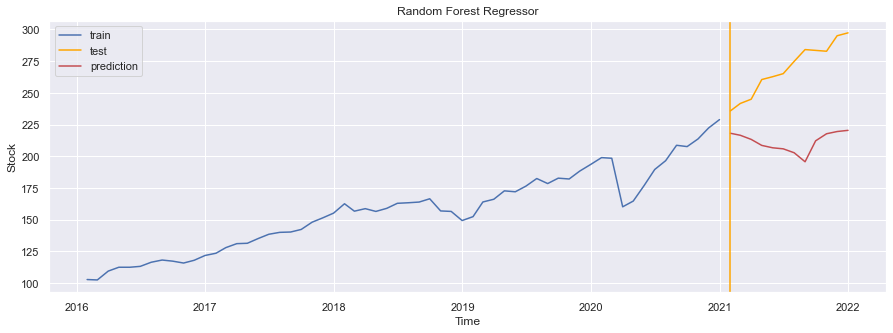

61.408

In [11]:
lin_analysis(df, _resampling = '1M', _debug = False, _method = 0)

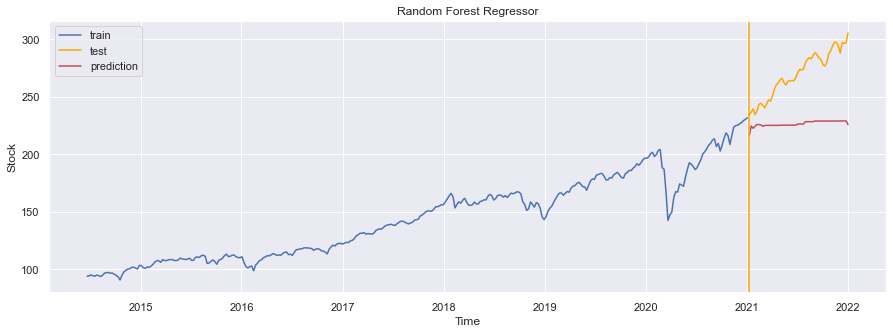

46.7508

In [12]:
lin_analysis(df, _resampling = '1W', _debug = False, _method = 0)

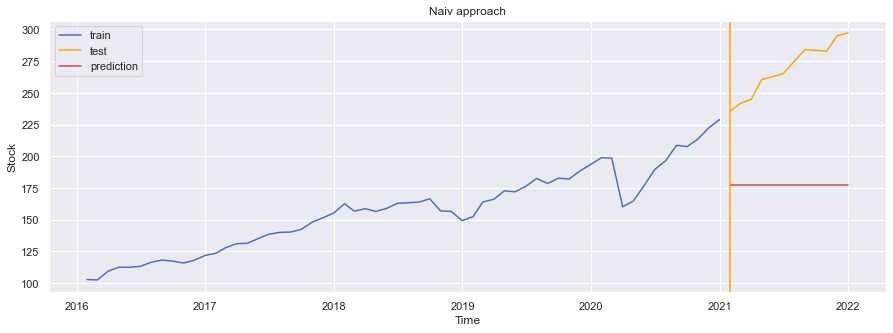

93.6421

In [13]:
lin_analysis(df, _resampling = '1M', _debug = False, _method = 1)

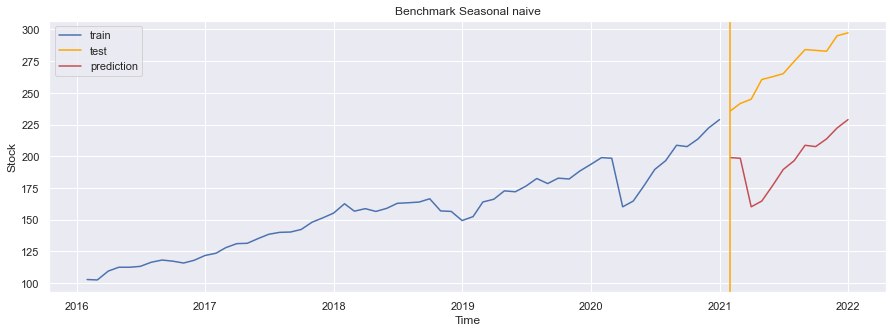

73.6062

In [14]:
lin_analysis(df, _resampling = '1M', _debug = False, _method = 2)

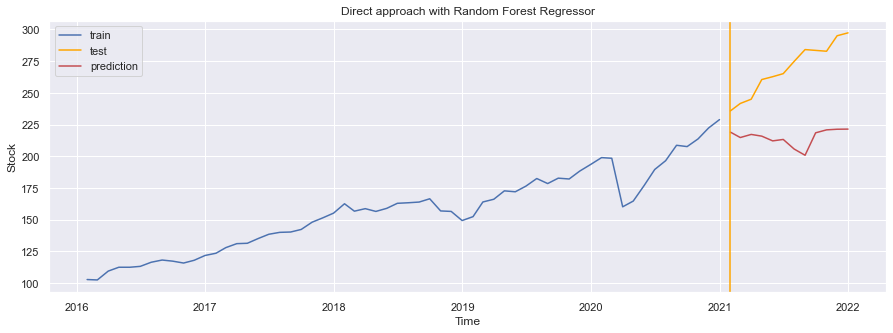

57.7402

In [15]:
lin_analysis(df, _resampling = '1M', _debug = False, _method = 3)

In [16]:
def prophet_analysis(_df = df, _resampling='1W', _debug=False, _method = 0):
    """
    Prophet forecast used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0 , 0: RandomForestRegressior, 1: Naiv, 2: Sesional naiv, 3: direct with RFR
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months TODO: lags is not used, but should be instead of steps
        steps = 12
        freq = 'MS'
    elif _resampling == '1W':
        lags = 156
        steps = 52
        freq = 'W'
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52

    # resampling
    df_resampled = _df.resample(_resampling).mean() 
    
    # create data frame ---- train
    df_pt = pd.DataFrame(df_resampled, index=df_resampled.index)
    df_pt['ds'] = df_pt.index
    df_pt.columns = ['y','ds']

    if _debug == True:
        print(df_pt.head())
       
    # remove nan-s -- not needed
    #df_pt = df_pt.dropna(axis=0)

    # train test split
    df_train_pt, df_test_pt = split_df_prediciton(df_pt,_resampling = _resampling)
    
    # overwrite steps -- TODO check
    steps = df_test_pt.shape[0]

    # model creation and fit
    model_pt = pt.Prophet(interval_width=0.95)
    model_pt.fit(df_train_pt)
    # INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
    # INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
    
    # prediction DF
    future_dates = model_pt.make_future_dataframe(periods = steps, freq = freq) # TODO MS ws montlhy?
    
    # prediction
    forecast = model_pt.predict(future_dates)
    
    # plot model component
    if _debug == True: 
        model_pt.plot_components(forecast)

    if _debug == True:
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

    # model plot
    #fig, ax = plt.subplots(figsize = (15,5))
    model_pt.plot(forecast, uncertainty=True,figsize = (15,5))

    #ax = y_save.plot()
    plt.plot(df_test_pt.index, df_test_pt['y'], c='orange', label='test')
    plt.axvline(x= df_test_pt.index[0], color='orange'); 

    # RSME calculation
    rmse =  np.sqrt(mean_squared_error(df_test_pt['y'], forecast.trend.tail(steps)))
    
    return np.round(rmse,4)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


55.5749

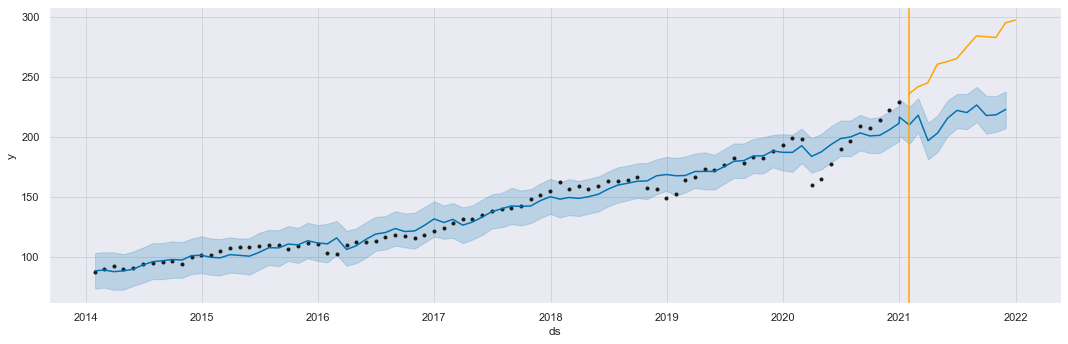

In [17]:
prophet_analysis(df, _resampling = '1M', _debug = False, _method = 0)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


46.4942

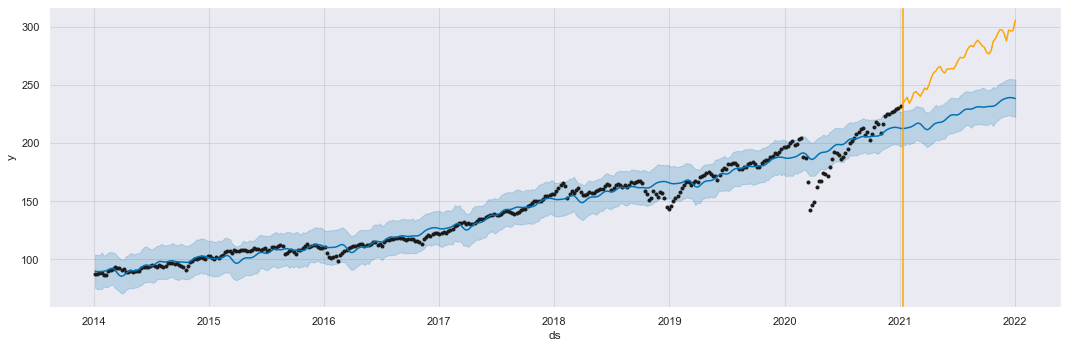

In [18]:
prophet_analysis(df, _resampling = '1W', _debug = False, _method = 0)

In [19]:
#################################
# NOTHING HAS BEEN DONE TO ANY CODE FURTHER BELOW
#################################